In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from transformers import DeiTForImageClassification, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
# ------------------------- Losses (your definitions) -------------------------
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        """
        features: (N, feat_dim)
        labels:   (N,) long
        """
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels.long())
        center_loss = torch.sum((features - centers_batch) ** 2) / (2.0 * batch_size)
        return center_loss


class MultiClassFocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        # inputs: (N, C) logits if self.logits=True; else probs
        # targets: (N,) long
        if self.logits:
            bce = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        else:
            bce = -torch.log(inputs[range(targets.shape[0]), targets].clamp(min=1e-12))
        pt = torch.exp(-bce)
        f_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return f_loss.mean() if self.reduce else f_loss


class FocalCenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, alpha=1, gamma=2, logits=True, reduce=True,
                 center_weight=1.0, focal_weight=1.0):
        super(FocalCenterLoss, self).__init__()
        self.center_loss = CenterLoss(num_classes, feat_dim, device)
        self.focal_loss = MultiClassFocalLoss(alpha, gamma, logits, reduce)
        self.center_weight = center_weight
        self.focal_weight = focal_weight

    def forward(self, features, labels, outputs):
        # features: (N, feat_dim)  | labels: (N,) long | outputs: (N, C) logits
        loss_center = self.center_loss(features, labels)
        loss_focal  = self.focal_loss(outputs, labels)
        return self.center_weight * loss_center + self.focal_weight * loss_focal


# ------------------------- Config -------------------------
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
batch_size = 128
epochs = 10

# Projection (embedding) size for center loss space
feat_dim = 256

# Loss weights
center_weight = 0.01    # tune 0.005–0.05
focal_weight  = 1.0

# Checkpoint path
save_path = "best_deit_fcl.pt"

# ------------------------- Data -------------------------
# (You can also use AutoImageProcessor to get exact DeiT normalization; ImageNet stats are fine here.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

# ------------------------- Backbone: DeiT (frozen) -------------------------
# Load HF classifier model; we will extract CLS from the internal DeiT encoder.
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", weights_only=False).to(device)
for p in model.parameters():
    p.requires_grad = False
model.eval()

# Make classifier a no-op to avoid accidental use
model.classifier = nn.Identity()

hidden_dim = model.config.hidden_size  # 768 for base

@torch.no_grad()
def extract_deit_cls(model, imgs: torch.Tensor) -> torch.Tensor:
    """
    Returns CLS embeddings from DeiT backbone.
    imgs: (N,3,224,224) ImageNet-normalized
    """
    out = model.deit(pixel_values=imgs, output_hidden_states=False, return_dict=True)
    return out.last_hidden_state[:, 0]  # (N, hidden_dim)

# ------------------------- Projection + Classifier + Loss -------------------------
proj = nn.Linear(hidden_dim, feat_dim).to(device)          # trainable projection to center-loss space
cls_head = nn.Linear(feat_dim, num_classes).to(device)     # multiclass head (logits)

criterion = FocalCenterLoss(
    num_classes=num_classes,
    feat_dim=feat_dim,
    device=device,
    alpha=1.0,
    gamma=2.0,
    logits=True,
    reduce=True,
    center_weight=center_weight,
    focal_weight=focal_weight,
).to(device)

optimizer = optim.Adam([
    {"params": proj.parameters(), "lr": 1e-3},
    {"params": cls_head.parameters(), "lr": 1e-3},
    {"params": criterion.center_loss.parameters(), "lr": 5e-4},  # smaller LR for centers
])

# ------------------------- Train / Eval -------------------------
def train_one_epoch():
    proj.train(); cls_head.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():
                feats_backbone = extract_deit_cls(model, imgs)  # (N, 768)
            feats = proj(feats_backbone)                       # (N, feat_dim)
            logits = cls_head(feats)                           # (N, C)
            loss = criterion(feats, y, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    proj.eval(); cls_head.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = proj(extract_deit_cls(model, imgs))
        logits = cls_head(feats)
        loss = criterion(feats, y, logits)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total

class_to_idx: {'Negative': 0, 'Positive': 1}


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:

# ------------------------- Run + Save-Best -------------------------
best_acc = 0.0
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()

    # save best
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),                   # frozen, but saved for reproducibility
            "proj_state_dict": proj.state_dict(),
            "cls_state_dict": cls_head.state_dict(),
            "center_state_dict": criterion.center_loss.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc,
            "num_classes": num_classes,
            "feat_dim": feat_dim,
        }, save_path)
        print(f"✅ New best acc: {best_acc:.3f} — saved to {save_path}")

    print(f"Epoch {epoch+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")

print(f"🔥 Done. Best Acc: {best_acc:.3f}")

Epoch 1/10 | train_loss 0.1020 | val_loss 0.2368 | acc 0.829


Epoch 2/10 | train_loss 0.0974 | val_loss 0.2188 | acc 0.853


Epoch 3/10 | train_loss 0.0956 | val_loss 0.2013 | acc 0.876


Epoch 4/10 | train_loss 0.1049 | val_loss 0.1918 | acc 0.889


Epoch 5/10 | train_loss 0.1024 | val_loss 0.1952 | acc 0.876


Epoch 6/10 | train_loss 0.0936 | val_loss 0.1956 | acc 0.880


Epoch 7/10 | train_loss 0.0886 | val_loss 0.1989 | acc 0.885


Epoch 8/10 | train_loss 0.0879 | val_loss 0.2619 | acc 0.857


Epoch 9/10 | train_loss 0.0976 | val_loss 0.2223 | acc 0.848


Epoch 10/10 | train_loss 0.0876 | val_loss 0.2039 | acc 0.853
🔥 Done. Best Acc: 0.899


In [2]:
# ------------------------- (Optional) How to load later -------------------------
ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
proj.load_state_dict(ckpt["proj_state_dict"])
cls_head.load_state_dict(ckpt["cls_state_dict"])
criterion.center_loss.load_state_dict(ckpt["center_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
print(f"Loaded. best_acc={ckpt['best_acc']:.3f}, epoch={ckpt['epoch']}")

Loaded. best_acc=0.899, epoch=2


              precision    recall  f1-score   support

    Negative     0.9245    0.9363    0.9304       157
    Positive     0.8276    0.8000    0.8136        60

    accuracy                         0.8986       217
   macro avg     0.8761    0.8682    0.8720       217
weighted avg     0.8977    0.8986    0.8981       217

Confusion Matrix:
 [[147  10]
 [ 12  48]]


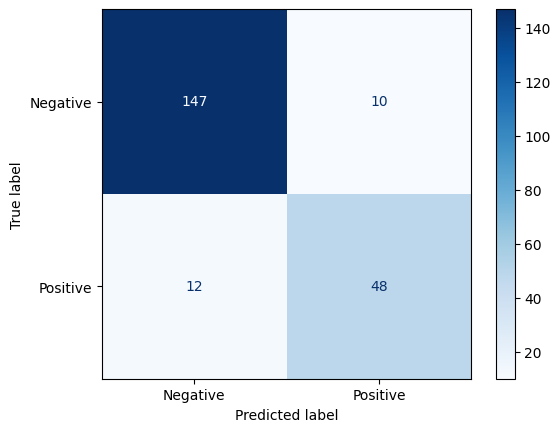

In [3]:
# ------------------------- Reports -------------------------
@torch.no_grad()
def collect_preds():
    proj.eval(); cls_head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = proj(extract_deit_cls(model, imgs))
        logits = cls_head(feats)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()

# ------------------------- (Optional) How to load later -------------------------
# ckpt = torch.load(save_path, map_location=device)
# model.load_state_dict(ckpt["model_state_dict"])
# proj.load_state_dict(ckpt["proj_state_dict"])
# cls_head.load_state_dict(ckpt["cls_state_dict"])
# criterion.center_loss.load_state_dict(ckpt["center_state_dict"])
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
# print(f"Loaded. best_acc={ckpt['best_acc']:.3f}, epoch={ckpt['epoch']}")
